In [ ]:
##########################################
# Nikolaos Paraskakis / I.D.: 2018030027 #
# Advanced Topics in Convex Optimization #
##########################################

In [ ]:
########################################################
#            Modern Portfolio Theory                   #
#             Portfolio Optimization                   #
#     Using Analytic Solutions and Combinatorics       #
########################################################

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 678 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 1.9 MB/s 


In [ ]:
# Import libraries

from pandas_datareader import data as web
from pandas_datareader import DataReader
import pandas as pd
import numpy as np
from datetime import datetime
import datetime 
import yfinance as yf
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import copy
import scipy.optimize as sc


In [ ]:
# Function to plot any graph

def plot_graph(col,title,xlabel,ylabel,df):

    data = []
    
    for i in range(len(col)): 
        plot = go.Scatter(x=df.index,y=df[col[i]], name=col[i])
        data.append(plot)
    
    layout = go.Layout(title= title,
                       xaxis=dict(title=xlabel),
                       yaxis=dict(title=ylabel ),
                       width = 690,
                       height = 500,
                       autosize = False)

    fig = go.Figure(data=data, layout=layout)
    
    fig.show()

In [ ]:
# Function to plot any table 

def plot_table(table, index_title = "", title = "" , layout_width = 900):
    
    colorscale = [[0, '#1a88ff'],[.5, '#e6f2ff'],[1, '#ffffff']]
    
    table = ff.create_table(round(table,4),
                            index = True,
                            index_title=index_title,
                            colorscale=colorscale )
    
    table.update_layout(title_text = title)
    
    table.layout.width=layout_width
    
    py.iplot(table)

In [ ]:
# FUNCTION to calculate portfolio performance

def portfolioPerformance(weights, annual_meanReturns, annual_covMatrix):

  annual_returns = np.dot(weights.T, annual_meanReturns)

  annual_variance = np.dot(weights.T, np.dot(annual_covMatrix, weights))

  annual_sd = np.sqrt(annual_variance)

  return annual_returns, annual_variance, annual_sd

In [ ]:
# FUNCTION to calculate portfolio volatility

def portfolioVolatility(weights, covMatrix):

  volatility = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)))

  return volatility

In [ ]:
# FUNCTION to calculate portfolio return

def portfolioReturn(weights, mean_returns):

  portReturn = np.dot(weights.T, mean_returns)

  return portReturn

In [ ]:
# FUNCTION to calculate negative portfolio return

def negativePortfolioReturn(weights, mean_returns):

  NegPortReturn = - portfolioReturn(weights, mean_returns)

  return NegPortReturn

In [ ]:
# FUNCTION to calculate Sharpe Ratio

def SR(weights, annual_meanReturns, annual_covMatrix, riskFreeRateOfReturn):
  
  annual_returns, annual_variance, annual_sd = portfolioPerformance(weights,
                                                                  annual_meanReturns,
                                                                  annual_covMatrix)
  
  portfolioRateOfReturn = annual_returns

  portfolio_sd = annual_sd

  SR = (portfolioRateOfReturn - riskFreeRateOfReturn)/portfolio_sd
  
  return SR

In [ ]:
# Get the symbols of the assets in the portfolio

# assets = ['META', 'AMZN', 'NFLX', 'GOOG', 'BA', 'V', 'MA', 'SNAP', 'CHPT', 'NUWE', 'MEGL', 'AMC']

assets = ['META', 'AMZN', 'NFLX', 'GOOG', 'BA', 'V', 'MA']

In [ ]:
# Assign equal weights to the assets (initial guess).

numOfAssets = len(assets)
weights = numOfAssets*[1./numOfAssets]

In [ ]:
# Get the stock/portfolio starting date
startDate = (datetime.datetime.today() - datetime.timedelta(days = 365*5)).strftime("%Y-%m-%d")

# Get the stock/portfolio ending date
endDate = datetime.datetime.today().strftime('%Y-%m-%d')

In [ ]:
# Create a dataframe to store the adjusted closing price of the stocks
df = pd.DataFrame()

# Store the adjusted closing price of the stock into the df
for asset in assets:
  df[asset] = yf.download(asset,
                          start = startDate,
                          end = endDate,
                          progress = False)['Adj Close']

my_assets = df

my_assets

,META,AMZN,NFLX,GOOG,BA,V,MA
Date,,,,,,,
2017-11-06,180.169998,56.033001,200.130005,51.294998,250.311264,108.355019,146.081131
2017-11-07,180.250000,56.158501,195.889999,51.666500,252.263901,108.519600,145.964417
2017-11-08,179.559998,56.644001,196.440002,51.992500,251.733124,108.887520,145.964417
2017-11-09,179.300003,56.456501,193.899994,51.563000,250.351257,108.568039,145.302505
2017-11-10,178.460007,56.267502,192.020004,51.403500,248.588226,108.316299,145.545822
...,...,...,...,...,...,...,...
2022-10-28,99.199997,103.410004,295.720001,96.580002,143.839996,209.339996,329.470001
2022-10-31,93.160004,102.440002,291.880005,94.660004,142.509995,207.160004,328.179993
2022-11-01,95.199997,96.790001,286.750000,90.500000,143.380005,206.929993,333.190002


In [ ]:
# Portfolio Adjusted Closing Price History

title = 'Portfolio Adjusted Closing Price History'
xlabel = 'Date'
ylabel = 'Adjusted Closing Price USD ($)'

col = list(my_assets.columns.values)
plot_graph(col,title,xlabel,ylabel,my_assets)

In [ ]:
# Plot the annual covariance matrix

#plot_table(annual_covMatrix)

In [ ]:
daily_returns = (my_assets-my_assets.shift(1))/my_assets.shift(1)
daily_returns = daily_returns.dropna()
daily_returns

,META,AMZN,NFLX,GOOG,BA,V,MA
Date,,,,,,,
2017-11-07,0.000444,0.002240,-0.021186,0.007242,0.007801,0.001519,-0.000799
2017-11-08,-0.003828,0.008645,0.002808,0.006310,-0.002104,0.003390,0.000000
2017-11-09,-0.001448,-0.003310,-0.012930,-0.008261,-0.005489,-0.002934,-0.004535
2017-11-10,-0.004685,-0.003348,-0.009696,-0.003093,-0.007042,-0.002319,0.001675
2017-11-13,0.001737,0.003394,0.015936,-0.002257,0.006019,-0.004290,0.001003
...,...,...,...,...,...,...,...
2022-10-28,0.012865,-0.068042,-0.004109,0.042981,0.029193,0.024720,0.031625
2022-10-31,-0.060887,-0.009380,-0.012985,-0.019880,-0.009246,-0.010414,-0.003915
2022-11-01,0.021898,-0.055154,-0.017576,-0.043947,0.006105,-0.001110,0.015266


In [ ]:
# Visually show the daily returns per asset

title = 'Percentage daily returns per asset'
xlabel = 'Date'
ylabel = 'Percentage daily returns'

col = list(daily_returns.columns.values)
plot_graph(col,title,xlabel,ylabel,daily_returns)

In [ ]:
# Mean daily volatility for each asset

daily_volatility = daily_returns.std()
daily_volatility = pd.DataFrame({'Asset':daily_volatility.index, 'Daily Volatility':daily_volatility.values})
plot_table(daily_volatility)

(-0.2, 0.2)

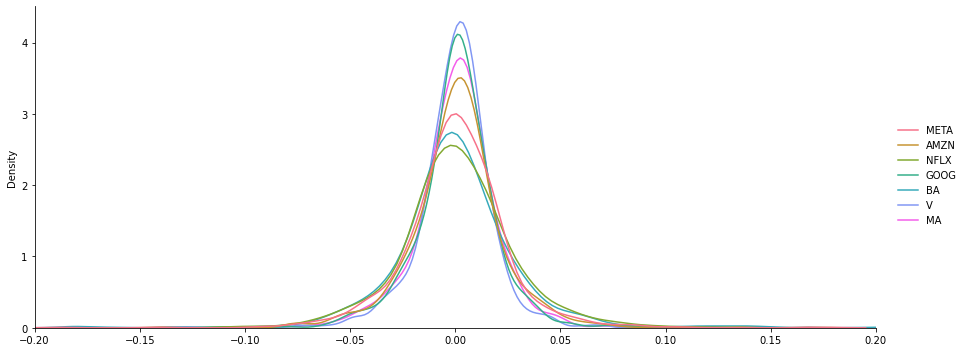

In [ ]:
# Density plot of the daily returns

sns.displot(data = daily_returns, kind = 'kde', aspect = 2.5)
plt.xlim(-0.2,0.2)

In [ ]:
# Annual volatility for each asset

annual_volatility = daily_volatility.loc[:,"Daily Volatility"] * np.sqrt(252)

annual_volatility = pd.DataFrame({'Asset':daily_volatility.loc[:,"Asset"], 'Annual Volatility':annual_volatility.values})

plot_table(annual_volatility)

In [ ]:
# Plot cumulative returns for each asset

daily_cum_returns = 1 + df.dropna().pct_change()
daily_cum_returns = daily_cum_returns.cumprod()*100

title = 'Cumulative returns for each asset'
xlabel = 'Date'
ylabel = 'Cumulative returns'

col = list(daily_cum_returns.columns.values)
plot_graph(col,title,xlabel,ylabel,daily_cum_returns)

In [ ]:
# Compute correlation matrix between assets

annual_cor_matrix = df.corr().round(3)

# plot_table(corr_df)

fig_corr = px.imshow(annual_cor_matrix, text_auto = True, title = 'Correlation matrix between assets')
fig_corr.show()

In [ ]:
# Compute covariance matrix between assets

annual_cov_matrix = (daily_returns.cov() * 252).round(3)

# plot_table(annual_cov_matrix)

fig_cov = px.imshow(annual_cov_matrix, text_auto = True, title = 'Covariance matrix between assets')
fig_cov.show()

In [ ]:
# Compute annual expected returns

annual_mean_returns = expected_returns.mean_historical_return(df)

annual_mean_returns_df = pd.DataFrame({'Asset':daily_volatility.loc[:,'Asset'], 'Annual Mean Returns':annual_mean_returns.values})

plot_table(annual_mean_returns_df)

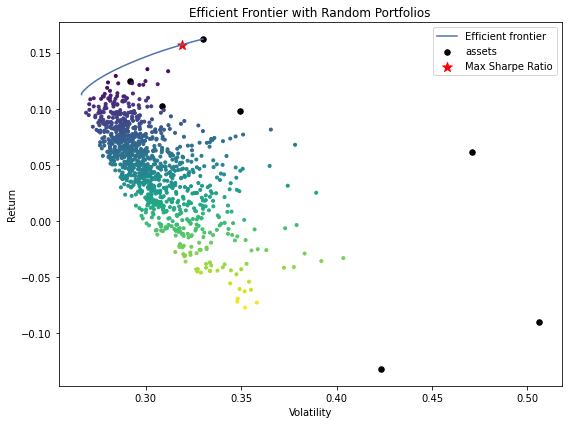

In [ ]:
def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0)
    ret_tangent, std_tangent, _ =   ef_max_sharpe.portfolio_performance(risk_free_rate=0)
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r",     label="Max Sharpe Ratio")
# Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
# Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(annual_mean_returns, annual_cov_matrix)

In [ ]:
# Print portfolio's performance
# Equal weights on each asset

annual_returns_0, annual_variance_0, annual_sd_0 = portfolioPerformance(np.array(weights),
                                                                  np.array(annual_mean_returns),
                                                                  annual_cov_matrix.to_numpy())

sharpeRatio_0 = SR(np.array(weights), np.array(annual_mean_returns), annual_cov_matrix.to_numpy(), 0)

percent_ret = str(round(annual_returns_0, 2) * 100) + '%'
percent_var = str(round(annual_variance_0, 2) * 100) + '%'
percent_sd = str(round(annual_sd_0, 2) * 100 ) + '%'

print('Expected annual return        : ' + percent_ret)
print('Annual variance               : ' + percent_var)
print('Annual volatility / risk / sd : ' + percent_sd)
print('Sharpe ratio                  : ' + str(round(sharpeRatio_0, 2)))

Expected annual return        : 5.0%
Annual variance               : 8.0%
Annual volatility / risk / sd : 28.999999999999996%
Sharpe ratio                  : 0.16


In [ ]:
#############################################
# Optimize portfolio for minimum volatility #
#############################################

In [ ]:
def minVolComb(ret, cov, lb=np.nan, ub=np.nan):
    """Markowitz minimizer with bounds constraints for a specified portfolio return

    Args:
        ret: A vector of N asset returns
        cov: NxN matrix of covariance of asset returns
        r (float): portfolio return to achieve
        lb, ub (float or vector): lowerbound and upperbound for the portfolio weights,
              if float, all weights are subject the same bound
    Returns:
		A (N+2) vector of portfolio weights and the Lagrange multipliers or
		None if no solution can be found
    """
    # Sanitation
    ret = np.array(ret).squeeze()
    cov = np.array(cov).squeeze()
    N = len(ret)
    if ret.shape != (N,):
        raise ValueError("Asset returns `ret` should be a vector")
    if cov.shape != (N,N):
        raise ValueError("Covariance matrix `cov` should be in shape ({},{}) to match the return vector".format(N,N))
    if isinstance(lb, (float,int)):
        lb = np.ones(N) * lb
    if isinstance(ub, (float,int)):
        ub = np.ones(N) * ub
    lb = lb.squeeze()
    ub = ub.squeeze()
    if lb.shape != (N,):
        raise ValueError("Lowerbound `lb` should be in shape (%d,) to match the return vector" % N)
    if ub.shape != (N,):
        raise ValueError("Upperbound `ub` should be in shape (%d,) to match the return vector" % N)
    if (lb > ub).any():
        raise ValueError("Lowerbound must no greater than upperbound")
    # Construct matrices as templates for the equation AX=B
    A = np.zeros((N+1+N+N,N+1+N+N))
    A[:N, :N] = cov
    A[:N, N] = A[N, :N] = np.ones(N)
    A[:N, N+1:N+N+1] = A[N+1:N+N+1, :N] = A[:N, N+N+1:] = A[N+N+1:, :N] = np.eye(N)
    b = np.zeros((N+1+N+N,1))
    b[N, 0] = 1
    b[N+1:N+N+1, 0] = lb
    b[N+N+1:, 0] = ub
    # Try all activeness combinations and track the best result to minimize objective
    bitmaps = 2**(2*N)
    best_obj = np.inf
    best_vector = None
    for bitmap in range(bitmaps):
        # constraints 0 to N-1 are for lowerbound and N to 2N-1 are for upperbound
        # row/column N+1+i corresponds to the constraint i
        inactive = [N+1+i for i in range(2*N) if bitmap & (2**i)]
        active = [N+1+i for i in range(2*N) if N+1+i not in inactive]
        # verify no conflicting active constraints
        if any(N+i in active for i in active):
            continue # conflicting activeness found, skip this one
        # Delete some rows and columns from the template for this activeness combination
        A_ = np.delete(np.delete(A, inactive, axis=0), inactive, axis=1)
        b_ = np.delete(b, inactive, axis=0)
        # Solve and check using matrix algebra
        try:
            x_ = (np.linalg.inv(A_) @ b_).squeeze()
            w = x_[:N]
            if (w < lb).any() or (w > ub).any():
                continue # solution not in feasible domain, try next one
            obj_val = w @ cov @ w # compute the covariance, i.e., objective function * 2
            if obj_val < best_obj:
                # Lower variance found, save the solution vector
                best_obj = obj_val
                x = np.zeros(N+1+N+N)
                x[:N+1] = x_[:N+1]    # w and negative lambda 
                x[active] = x_[N+1:]  # negative theta and phi
                x[N:N+1+N] *= -1      # lambda and theta are negated
                best_vector = x
        except np.linalg.LinAlgError:
            pass # no solution found for this combination
    return best_vector

In [ ]:
result = minVolComb(np.array(annual_mean_returns), annual_cov_matrix.to_numpy(), 0, 1)

weights_1 = result[0:numOfAssets]

weights_1_df = pd.DataFrame({'Asset':daily_volatility.loc[:,'Asset'], 'Weights_1':weights_1})

weights_1_dict = dict(zip(assets, weights_1.T))

plot_table(weights_1_df)

In [ ]:
# Print portfolio's performance

annual_returns_1, annual_variance_1, annual_sd_1 = portfolioPerformance(np.array(weights_1),
                                                                        np.array(annual_mean_returns),
                                                                        annual_cov_matrix.to_numpy())

sharpeRatio_1 = SR(np.array(weights_1), np.array(annual_mean_returns), annual_cov_matrix.to_numpy(), 0)

percent_ret = str(round(annual_returns_1, 2) * 100) + '%'
percent_sd = str(round(annual_sd_1, 2) * 100 ) + '%'

print('Expected annual return        : ' + percent_ret)
print('Annual volatility / risk / sd : ' + percent_sd)
print('Sharpe ratio                  : ' + str(round(sharpeRatio_1, 2)))

Expected annual return        : 11.0%
Annual volatility / risk / sd : 27.0%
Sharpe ratio                  : 0.42


In [ ]:
# Generate Portfolio with Optimized Weights

# Now let us generate the portfolio with optimized weights and plot out its cumulative returns over time.

my_assets_1 = my_assets.copy(deep=True)
my_assets_1['Optimized Portfolio'] = 0
for asset, weight in weights_1_dict.items():
    my_assets_1['Optimized Portfolio'] += my_assets_1[asset]*weight

my_assets_1

,META,AMZN,NFLX,GOOG,BA,V,MA,Optimized Portfolio
Date,,,,,,,,
2017-11-06,180.169998,56.033001,200.130005,51.294998,250.311264,108.355019,146.081131,85.509591
2017-11-07,180.250000,56.158501,195.889999,51.666500,252.263901,108.519600,145.964417,85.629968
2017-11-08,179.559998,56.644001,196.440002,51.992500,251.733124,108.887520,145.964417,86.012128
2017-11-09,179.300003,56.456501,193.899994,51.563000,250.351257,108.568039,145.302505,85.641241
2017-11-10,178.460007,56.267502,192.020004,51.403500,248.588226,108.316299,145.545822,85.391508
...,...,...,...,...,...,...,...,...
2022-10-28,99.199997,103.410004,295.720001,96.580002,143.839996,209.339996,329.470001,161.744596
2022-10-31,93.160004,102.440002,291.880005,94.660004,142.509995,207.160004,328.179993,159.821034
2022-11-01,95.199997,96.790001,286.750000,90.500000,143.380005,206.929993,333.190002,157.449853


In [ ]:
# Plot cumulative returns for each asset

my_df = my_assets_1[['Optimized Portfolio']]
daily_cum_returns_opt = 1 + my_df.dropna().pct_change()
daily_cum_returns_opt = daily_cum_returns_opt.cumprod()*100

title = 'Cumulative Returns of Optimized Portfolio Starting with $100'
xlabel = 'Date'
ylabel = 'Cumulative returns'

col = list(daily_cum_returns_opt.dropna())
plot_graph(col,title,xlabel,ylabel,daily_cum_returns_opt.dropna())

In [ ]:
# Get the discrete allocation of each share per stock

latest_prices = get_latest_prices(my_assets)
da = DiscreteAllocation(weights_1_dict, latest_prices, total_portfolio_value = 10000)

allocation, leftover = da.lp_portfolio()

print('Latest prices of assets:\n')

print(latest_prices)
print ('\nDiscrete allocation:',allocation)
print('Funds remaining: ${:.2f}'.format (leftover))

Latest prices of assets:

META     88.910004
AMZN     89.300003
NFLX    269.059998
GOOG     83.489998
BA      156.750000
V       194.750000
MA      309.170013
Name: 2022-11-03 00:00:00, dtype: float64

Discrete allocation: {'AMZN': 20, 'NFLX': 1, 'GOOG': 32, 'V': 27}
Funds remaining: $15.01


In [ ]:
###################################################################
# Optimize portfolio by minimizing risk for a given target return #
###################################################################

In [ ]:
def efRiskOnTargetReturnComb(r, ret, cov, lb=np.nan, ub=np.nan):
    """Markowitz minimizer with bounds constraints for a specified portfolio return

    Args:
        ret: A vector of N asset returns
        cov: NxN matrix of covariance of asset returns
        r (float): portfolio return to achieve
        lb, ub (float or vector): lowerbound and upperbound for the portfolio weights,
              if float, all weights are subject the same bound
    Returns:
		A (N+2) vector of portfolio weights and the Lagrange multipliers or
		None if no solution can be found
    """
    # Sanitation
    ret = np.array(ret).squeeze()
    cov = np.array(cov).squeeze()
    r = float(r)
    N = len(ret)
    if ret.shape != (N,):
        raise ValueError("Asset returns `ret` should be a vector")
    if cov.shape != (N,N):
        raise ValueError("Covariance matrix `cov` should be in shape ({},{}) to match the return vector".format(N,N))
    if isinstance(lb, (float,int)):
        lb = np.ones(N) * lb
    if isinstance(ub, (float,int)):
        ub = np.ones(N) * ub
    lb = lb.squeeze()
    ub = ub.squeeze()
    if lb.shape != (N,):
        raise ValueError("Lowerbound `lb` should be in shape (%d,) to match the return vector" % N)
    if ub.shape != (N,):
        raise ValueError("Upperbound `ub` should be in shape (%d,) to match the return vector" % N)
    if (lb > ub).any():
        raise ValueError("Lowerbound must no greater than upperbound")
    # Construct matrices as templates for the equation AX=B
    A = np.zeros((N+2+N+N,N+2+N+N))
    A[:N, :N] = cov
    A[:N, N] = A[N, :N] = ret
    A[:N, N+1] = A[N+1, :N] = np.ones(N)
    A[:N, N+2:N+N+2] = A[N+2:N+N+2, :N] = A[:N, N+N+2:] = A[N+N+2:, :N] = np.eye(N)
    b = np.zeros((N+2+N+N,1))
    b[N:N+2, 0] = [r, 1]
    b[N+2:N+N+2, 0] = lb
    b[N+N+2:, 0] = ub
    print(A.shape)
    print(b.shape)
    # Try all activeness combinations and track the best result to minimize objective
    bitmaps = 2**(2*N)
    best_obj = np.inf
    best_vector = None
    for bitmap in range(bitmaps):
        # constraints 0 to N-1 are for lowerbound and N to 2N-1 are for upperbound
        # row/column N+2+i corresponds to the constraint i
        inactive = [N+2+i for i in range(2*N) if bitmap & (2**i)]
        active = [N+2+i for i in range(2*N) if N+2+i not in inactive]
        # verify no conflicting active constraints
        if any(N+i in active for i in active):
            continue # conflicting activeness found, skip this one
        # Delete some rows and columns from the template for this activeness combination
        A_ = np.delete(np.delete(A, inactive, axis=0), inactive, axis=1)
        b_ = np.delete(b, inactive, axis=0)
        # Solve and check using matrix algebra
        try:
            x_ = (np.linalg.inv(A_) @ b_).squeeze()
            w = x_[:N]
            if (w < lb).any() or (w > ub).any():
                continue # solution not in feasible domain, try next one
            obj_val = w @ cov @ w # compute the covariance, i.e., objective function * 2
            if obj_val < best_obj:
                # Lower variance found, save the solution vector
                best_obj = obj_val
                x = np.zeros(N+2+N+N)
                x[:N+2] = x_[:N+2]    # w and negative lambda 
                x[active] = x_[N+2:]  # negative theta and phi
                x[N:N+2+N] *= -1      # lambda and theta are negated
                best_vector = x
        except np.linalg.LinAlgError:
            pass # no solution found for this combination
    return best_vector

In [ ]:
result = efRiskOnTargetReturnComb(0.15, np.array(annual_mean_returns), annual_cov_matrix.to_numpy(), 0, 1)

weights_4 = result[0:numOfAssets]

weights_4_df = pd.DataFrame({'Asset':daily_volatility.loc[:,'Asset'], 'Weights_4':weights_4})

weights_4_dict = dict(zip(assets, weights_4.T))

plot_table(weights_4_df)

(23, 23)
(23, 1)


In [ ]:
# Print portfolio's performance

annual_returns_4, annual_variance_4, annual_sd_4 = portfolioPerformance(np.array(weights_4),
                                                                        np.array(annual_mean_returns),
                                                                        annual_cov_matrix.to_numpy())

sharpeRatio_4 = SR(np.array(weights_4), np.array(annual_mean_returns), annual_cov_matrix.to_numpy(), 0)

percent_ret = str(round(annual_returns_4, 2) * 100) + '%'
percent_sd = str(round(annual_sd_4, 2) * 100 ) + '%'

print('Expected annual return        : ' + percent_ret)
print('Annual volatility / risk / sd : ' + percent_sd)
print('Sharpe ratio                  : ' + str(round(sharpeRatio_4, 2)))

Expected annual return        : 15.0%
Annual volatility / risk / sd : 31.0%
Sharpe ratio                  : 0.49


In [ ]:
# Generate Portfolio with Optimized Weights

# Now let us generate the portfolio with optimized weights and plot out its cumulative returns over time.

my_assets_4 = my_assets.copy(deep=True)
my_assets_4['Optimized Portfolio'] = 0
for asset, weight in weights_4_dict.items():
    my_assets_4['Optimized Portfolio'] += my_assets_4[asset]*weight

my_assets_4

,META,AMZN,NFLX,GOOG,BA,V,MA,Optimized Portfolio
Date,,,,,,,,
2017-11-06,180.169998,56.033001,200.130005,51.294998,250.311264,108.355019,146.081131,127.718073
2017-11-07,180.250000,56.158501,195.889999,51.666500,252.263901,108.519600,145.964417,127.677327
2017-11-08,179.559998,56.644001,196.440002,51.992500,251.733124,108.887520,145.964417,127.755251
2017-11-09,179.300003,56.456501,193.899994,51.563000,250.351257,108.568039,145.302505,127.159669
2017-11-10,178.460007,56.267502,192.020004,51.403500,248.588226,108.316299,145.545822,127.320778
...,...,...,...,...,...,...,...,...
2022-10-28,99.199997,103.410004,295.720001,96.580002,143.839996,209.339996,329.470001,283.947715
2022-10-31,93.160004,102.440002,291.880005,94.660004,142.509995,207.160004,328.179993,282.612815
2022-11-01,95.199997,96.790001,286.750000,90.500000,143.380005,206.929993,333.190002,285.682636


In [ ]:
# Plot cumulative returns for each asset

my_df = my_assets_4[['Optimized Portfolio']]
daily_cum_returns_opt = 1 + my_df.dropna().pct_change()
daily_cum_returns_opt = daily_cum_returns_opt.cumprod()*100

title = 'Cumulative Returns of Optimized Portfolio Starting with $100'
xlabel = 'Date'
ylabel = 'Cumulative returns'

col = list(daily_cum_returns_opt.dropna())
plot_graph(col,title,xlabel,ylabel,daily_cum_returns_opt.dropna())

In [ ]:
# Get the discrete allocation of each share per stock

latest_prices = get_latest_prices(my_assets)
da = DiscreteAllocation(weights_4_dict, latest_prices, total_portfolio_value = 10000)

allocation, leftover = da.lp_portfolio()

print('Latest prices of assets:\n')

print(latest_prices)
print ('\nDiscrete allocation:',allocation)
print('Funds remaining: ${:.2f}'.format (leftover))

Latest prices of assets:

META     88.910004
AMZN     89.300003
NFLX    269.059998
GOOG     83.489998
BA      156.750000
V       194.750000
MA      309.170013
Name: 2022-11-03 00:00:00, dtype: float64

Discrete allocation: {'AMZN': 9, 'GOOG': 13, 'MA': 26}
Funds remaining: $72.51


In [ ]:
############################################
# Optimize portfolio by maximizing utility #
############################################

In [ ]:
def maxUtilityComb(risk_aversion, ret, cov, lb=np.nan, ub=np.nan):
    """Markowitz minimizer with bounds constraints for a specified portfolio return

    Args:
        ret: A vector of N asset returns
        cov: NxN matrix of covariance of asset returns
        r (float): portfolio return to achieve
        lb, ub (float or vector): lowerbound and upperbound for the portfolio weights,
              if float, all weights are subject the same bound
    Returns:
		A (N+2) vector of portfolio weights and the Lagrange multipliers or
		None if no solution can be found
    """
    # Sanitation
    ret = np.array(ret).squeeze()
    cov = np.array(cov).squeeze()
    N = len(ret)
    if ret.shape != (N,):
        raise ValueError("Asset returns `ret` should be a vector")
    if cov.shape != (N,N):
        raise ValueError("Covariance matrix `cov` should be in shape ({},{}) to match the return vector".format(N,N))
    if isinstance(lb, (float,int)):
        lb = np.ones(N) * lb
    if isinstance(ub, (float,int)):
        ub = np.ones(N) * ub
    lb = lb.squeeze()
    ub = ub.squeeze()
    if lb.shape != (N,):
        raise ValueError("Lowerbound `lb` should be in shape (%d,) to match the return vector" % N)
    if ub.shape != (N,):
        raise ValueError("Upperbound `ub` should be in shape (%d,) to match the return vector" % N)
    if (lb > ub).any():
        raise ValueError("Lowerbound must no greater than upperbound")
    # Construct matrices as templates for the equation AX=B
    A = np.zeros((N+1+N+N,N+1+N+N))
    A[:N, :N] = risk_aversion * cov
    A[:N, N] = A[N, :N] = np.ones(N)
    A[:N, N+1:N+N+1] = A[N+1:N+N+1, :N] = A[:N, N+N+1:] = A[N+N+1:, :N] = np.eye(N)
    b = np.zeros((N+1+N+N,1))
    b[0:N, 0] = ret
    b[N, 0] = 1
    b[N+1:N+N+1, 0] = lb
    b[N+N+1:, 0] = ub
    # Try all activeness combinations and track the best result to minimize objective
    bitmaps = 2**(2*N)
    best_obj = np.inf
    best_vector = None
    for bitmap in range(bitmaps):
        # constraints 0 to N-1 are for lowerbound and N to 2N-1 are for upperbound
        # row/column N+1+i corresponds to the constraint i
        inactive = [N+1+i for i in range(2*N) if bitmap & (2**i)]
        active = [N+1+i for i in range(2*N) if N+1+i not in inactive]
        # verify no conflicting active constraints
        if any(N+i in active for i in active):
            continue # conflicting activeness found, skip this one
        # Delete some rows and columns from the template for this activeness combination
        A_ = np.delete(np.delete(A, inactive, axis=0), inactive, axis=1)
        b_ = np.delete(b, inactive, axis=0)
        # Solve and check using matrix algebra
        try:
            x_ = (np.linalg.inv(A_) @ b_).squeeze()
            w = x_[:N]
            if (w < lb).any() or (w > ub).any():
                continue # solution not in feasible domain, try next one
            obj_val = - w @ ret + ((1/2) * risk_aversion) * (w @ cov @ w) # compute the covariance, i.e., objective function * 2
            if obj_val < best_obj:
                # Lower variance found, save the solution vector
                best_obj = obj_val
                x = np.zeros(N+1+N+N)
                x[:N+1] = x_[:N+1]    # w and negative lambda 
                x[active] = x_[N+1:]  # negative theta and phi
                x[N:N+1+N] *= -1      # lambda and theta are negated
                best_vector = x
        except np.linalg.LinAlgError:
            pass # no solution found for this combination
    return best_vector

In [ ]:
result = maxUtilityComb(1, np.array(annual_mean_returns), annual_cov_matrix.to_numpy(), 0, 1)

weights_5 = result[0:numOfAssets]

weights_5_df = pd.DataFrame({'Asset':daily_volatility.loc[:,'Asset'], 'Weights_5':weights_5})

weights_5_dict = dict(zip(assets, weights_5.T))

plot_table(weights_5_df)

In [ ]:
# Print portfolio's performance

annual_returns_5, annual_variance_5, annual_sd_5 = portfolioPerformance(np.array(weights_5),
                                                                        np.array(annual_mean_returns),
                                                                        annual_cov_matrix.to_numpy())

sharpeRatio_5 = SR(np.array(weights_5), np.array(annual_mean_returns), annual_cov_matrix.to_numpy(), 0)

percent_ret = str(round(annual_returns_5, 2) * 100) + '%'
percent_sd = str(round(annual_sd_5, 2) * 100 ) + '%'

print('Expected annual return        : ' + percent_ret)
print('Annual volatility / risk / sd : ' + percent_sd)
print('Sharpe ratio                  : ' + str(round(sharpeRatio_5, 2)))

Expected annual return        : 16.0%
Annual volatility / risk / sd : 33.0%
Sharpe ratio                  : 0.49


In [ ]:
# Generate Portfolio with Optimized Weights

# Now let us generate the portfolio with optimized weights and plot out its cumulative returns over time.

my_assets_5 = my_assets.copy(deep=True)
my_assets_5['Optimized Portfolio'] = 0
for asset, weight in weights_4_dict.items():
    my_assets_5['Optimized Portfolio'] += my_assets_5[asset]*weight

my_assets_5

,META,AMZN,NFLX,GOOG,BA,V,MA,Optimized Portfolio
Date,,,,,,,,
2017-11-06,180.169998,56.033001,200.130005,51.294998,250.311264,108.355019,146.081131,127.718073
2017-11-07,180.250000,56.158501,195.889999,51.666500,252.263901,108.519600,145.964417,127.677327
2017-11-08,179.559998,56.644001,196.440002,51.992500,251.733124,108.887520,145.964417,127.755251
2017-11-09,179.300003,56.456501,193.899994,51.563000,250.351257,108.568039,145.302505,127.159669
2017-11-10,178.460007,56.267502,192.020004,51.403500,248.588226,108.316299,145.545822,127.320778
...,...,...,...,...,...,...,...,...
2022-10-28,99.199997,103.410004,295.720001,96.580002,143.839996,209.339996,329.470001,283.947715
2022-10-31,93.160004,102.440002,291.880005,94.660004,142.509995,207.160004,328.179993,282.612815
2022-11-01,95.199997,96.790001,286.750000,90.500000,143.380005,206.929993,333.190002,285.682636


In [ ]:
# Plot cumulative returns for each asset

my_df = my_assets_5[['Optimized Portfolio']]
daily_cum_returns_opt = 1 + my_df.dropna().pct_change()
daily_cum_returns_opt = daily_cum_returns_opt.cumprod()*100

title = 'Cumulative Returns of Optimized Portfolio Starting with $100'
xlabel = 'Date'
ylabel = 'Cumulative returns'

col = list(daily_cum_returns_opt.dropna())
plot_graph(col,title,xlabel,ylabel,daily_cum_returns_opt.dropna())

In [ ]:
# Get the discrete allocation of each share per stock

latest_prices = get_latest_prices(my_assets)
da = DiscreteAllocation(weights_5_dict, latest_prices, total_portfolio_value = 10000)

allocation, leftover = da.lp_portfolio()

print('Latest prices of assets:\n')

print(latest_prices)
print ('\nDiscrete allocation:',allocation)
print('Funds remaining: ${:.2f}'.format (leftover))

Latest prices of assets:

META     88.910004
AMZN     89.300003
NFLX    269.059998
GOOG     83.489998
BA      156.750000
V       194.750000
MA      309.170013
Name: 2022-11-03 00:00:00, dtype: float64

Discrete allocation: {'MA': 32}
Funds remaining: $106.56


In [ ]:
import scipy.io
cm = annual_cov_matrix.to_numpy()
scipy.io.savemat('covMat.mat',dict(x=cm))

In [ ]:
scipy.io.savemat('meanReturns.mat',dict(x=np.array(annual_mean_returns)))